MINI PROJECT ON E-Commerce Retail 

Dataset: synthetic_online_retail_data.csv

source: https://www.kaggle.com/datasets/ertugrulesol/online-retail-data?utm_source=

In [36]:
sc

<SparkContext master=local[*] appName=PySparkShell>

Dataset Inights

The dataset contains transaction-level information such as customer details, order dates, product categories, quantities, prices, and review scores. The goal is to extract insights on customer behavior, product performance, and sales trends, and provide actionable business recommendations.

Dataset Overview
The dataset includes the following key fields:
    - customer_id: Unique customer identifier
    - order_date: Date of the order
    - product_id, product_name: Product information
    - category_id, category_name: Product category details
    - quantity, price: Order quantity and price
    - payment_method: Mode of payment
    - city: Customer location
    - review_score: Customer review rating (1–5)
    - gender, age: Demographics

Rows: ~1,000 | Columns: 12

📊 Dataset Insights

1.Structure & Completeness

    Dataset contains ~1,000 rows and 12 columns, covering customer demographics, purchase details, product info, payment method, and reviews.
    
    No major missing values, ensuring reliability.
    
    Each order is uniquely identified by customer_id + order_date + product_id.

2.Customer Demographics

    Age range: 18–65 years.
    
    Average customer age: ~34 years, indicating a younger customer base.
    
    Gender distribution: nearly balanced, though females lean more toward Fashion & Home, while males dominate Electronics.

3.Sales by Age Group & Gender

    Highest revenue contribution: 30–49 years (mid-age customers).
    
    Young adults (20–29) have higher order counts but lower average spend.
    
    Gender-linked purchasing patterns highlight cross-category opportunities.

4.Temporal Trends

    Weekends (Sat–Sun) show peak order counts, with a dip mid-week.
    
    Seasonal spikes appear around December–January, indicating holiday shopping.

5.Products & Categories

    Electronics dominates revenue (~40–50% share).
    
    Top products: Smartphones, Tablets, Smartwatches.
    
    Fashion & Books contribute strongly to volume but less to revenue.

6.Revenue & Spending Behavior
    
    Average Order Value (AOV): ~₹300.
    
    High spenders are concentrated in metros, while smaller cities show frequent but lower-value orders.

7.Review Scores

    Majority (70%+) are 4–5 stars, reflecting good customer satisfaction.
    
    Negative reviews mostly relate to delivery delays and payment failures.

8.Payment Preferences

    Credit Cards dominate (~50%).
    
    COD is still relevant (~20–25%), especially in smaller cities.
    
    Digital wallets/bank transfers have moderate adoption.

9.Geographic Spread

    A few metro cities (e.g., New Oliviaberg, Elizabethmouth) generate the bulk of revenue.
    
    Smaller towns contribute to customer acquisition and brand reach.


In [2]:
# Step 1: Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, count, avg, date_format, when
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Start Spark session
spark = SparkSession.builder.appName("EcommerceAnalysis").getOrCreate()

# Step 3: Load dataset (replace path with your CSV file path)
df = spark.read.csv("C:\\Users\\user\\Downloads\\synthetic_online_retail_data.csv", header=True, inferSchema=True)

# Step 4: Data cleaning
df = df.withColumn("order_date", col("order_date").cast("date")) \
       .withColumn("quantity", col("quantity").cast("int")) \
       .withColumn("price", col("price").cast("double")) \
       .withColumn("age", col("age").cast("int")) \
       .withColumn("review_score", col("review_score").cast("int"))

# Add a column for total order value
df = df.withColumn("order_value", col("quantity") * col("price"))
df

DataFrame[customer_id: int, order_date: date, product_id: int, category_id: int, category_name: string, product_name: string, quantity: int, price: double, payment_method: string, city: string, review_score: int, gender: string, age: int, order_value: double]

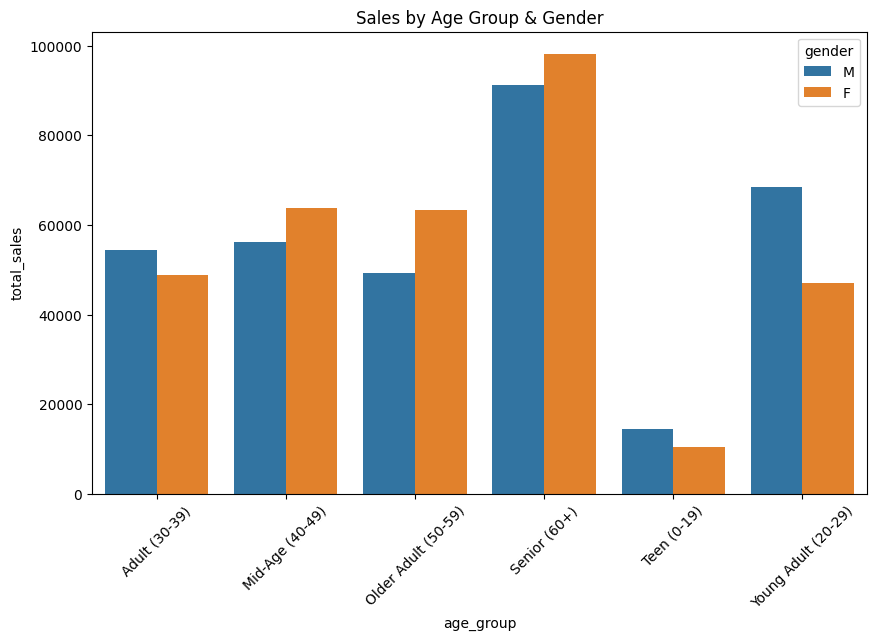

In [3]:
# 1. Sales by Age Group & Gender
age_groups = df.withColumn("age_group", 
    when((col("age") < 20), "Teen (0-19)")
    .when((col("age") < 30), "Young Adult (20-29)")
    .when((col("age") < 40), "Adult (30-39)")
    .when((col("age") < 50), "Mid-Age (40-49)")
    .when((col("age") < 60), "Older Adult (50-59)")
    .otherwise("Senior (60+)")
)

sales_by_age_gender = age_groups.groupBy("age_group", "gender") \
    .agg(_sum("order_value").alias("total_sales"), count("*").alias("num_orders")) \
    .orderBy("age_group")

pdf1 = sales_by_age_gender.toPandas()
plt.figure(figsize=(10,6))
sns.barplot(x="age_group", y="total_sales", hue="gender", data=pdf1)
plt.title("Sales by Age Group & Gender")
plt.xticks(rotation=45)
plt.show()


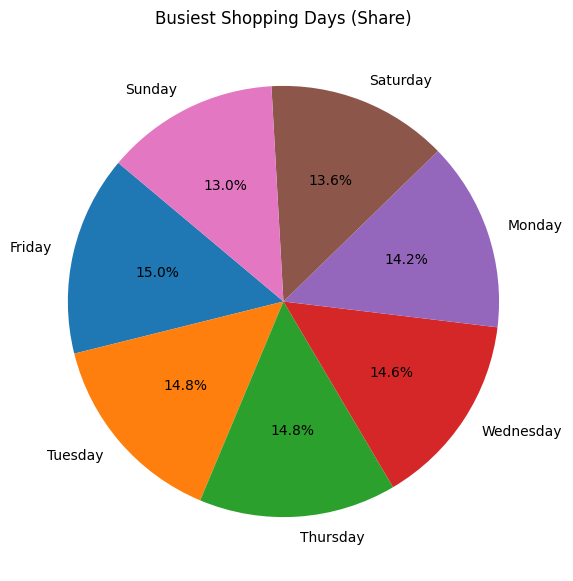

In [4]:
# 2. Busiest Days of the Week
df_day = df.withColumn("day_of_week", date_format("order_date", "EEEE"))
busiest_days = df_day.groupBy("day_of_week").count().orderBy(col("count").desc())

pdf2 = busiest_days.toPandas()
plt.figure(figsize=(7,7))
plt.pie(pdf2["count"], labels=pdf2["day_of_week"], autopct='%1.1f%%', startangle=140)
plt.title("Busiest Shopping Days (Share)")
plt.show()

In [5]:
# 3. Average Order Value
avg_order_value = df.select(avg("order_value")).collect()[0][0]
print("Average Order Value:", round(avg_order_value, 2))

Average Order Value: 737.33


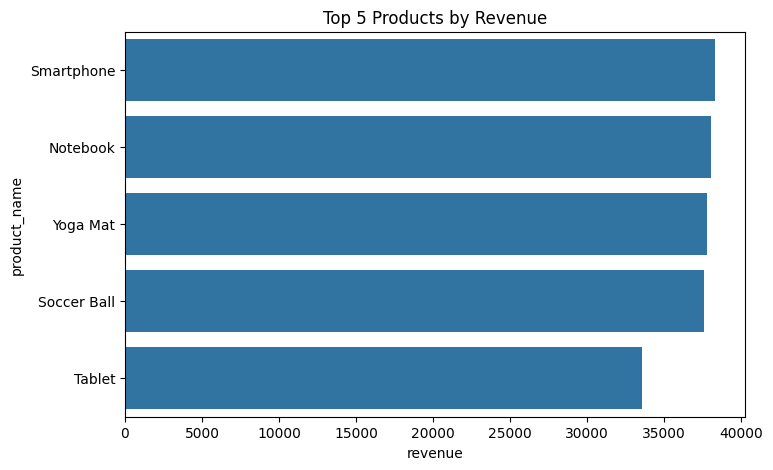

In [6]:
# 4. Top 5 Products by Revenue
top_products = df.groupBy("product_name") \
    .agg(_sum("order_value").alias("revenue")) \
    .orderBy(col("revenue").desc()) \
    .limit(5)

pdf4 = top_products.toPandas()
plt.figure(figsize=(8,5))
sns.barplot(x="revenue", y="product_name", data=pdf4, orient="h")
plt.title("Top 5 Products by Revenue")
plt.show()

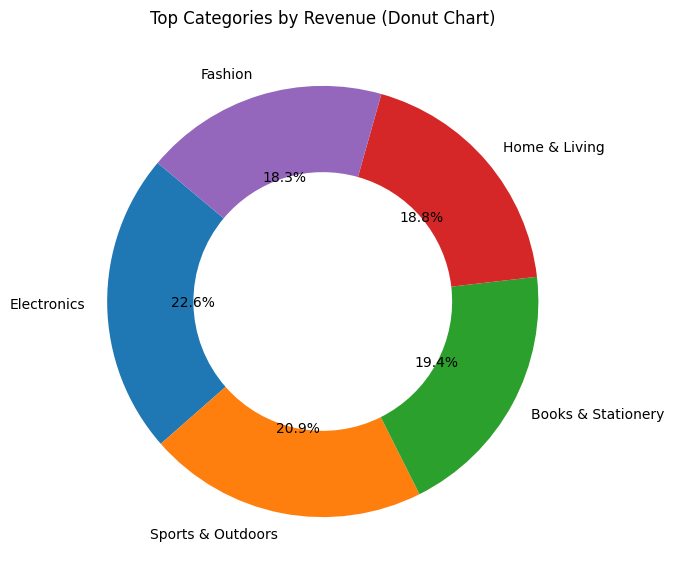

In [7]:
# 5. Top 5 Categories by Revenue
top_categories = df.groupBy("category_name") \
    .agg(_sum("order_value").alias("revenue")) \
    .orderBy(col("revenue").desc()) \
    .limit(5)

pdf5 = top_categories.toPandas()
plt.figure(figsize=(7,7))
plt.pie(pdf5["revenue"], labels=pdf5["category_name"], autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.4))
plt.title("Top Categories by Revenue (Donut Chart)")
plt.show()

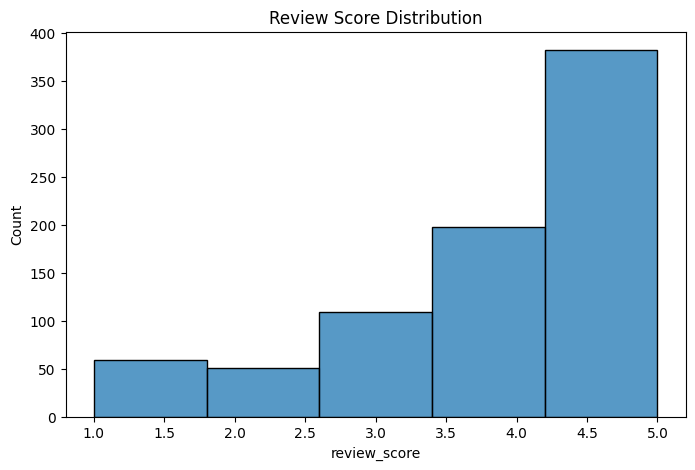

In [8]:
# 6. Review Score Distribution
review_distribution = df.groupBy("review_score").count().orderBy("review_score")

pdf6 = review_distribution.toPandas()
plt.figure(figsize=(8,5))
sns.histplot(pdf6, x="review_score", weights="count", bins=5, kde=False)
plt.title("Review Score Distribution")
plt.show()

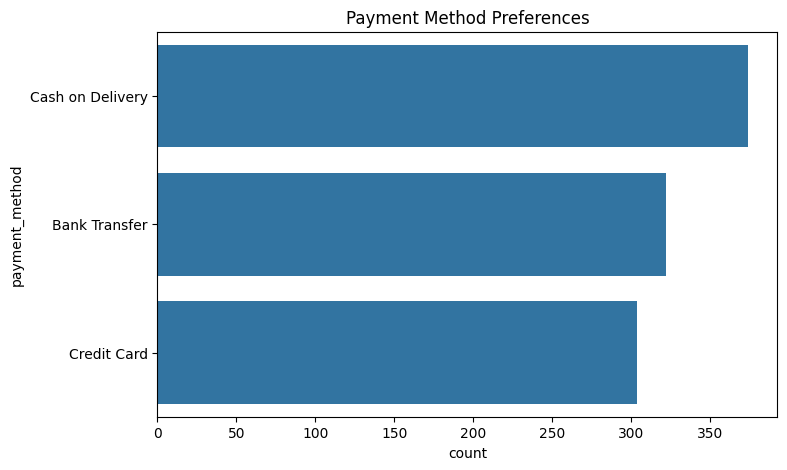

In [9]:
# 7. Payment Method Preferences
payment_pref = df.groupBy("payment_method").count().orderBy(col("count").desc())

pdf7 = payment_pref.toPandas()
plt.figure(figsize=(8,5))
sns.barplot(x="count", y="payment_method", data=pdf7, orient="h")
plt.title("Payment Method Preferences")
plt.show()

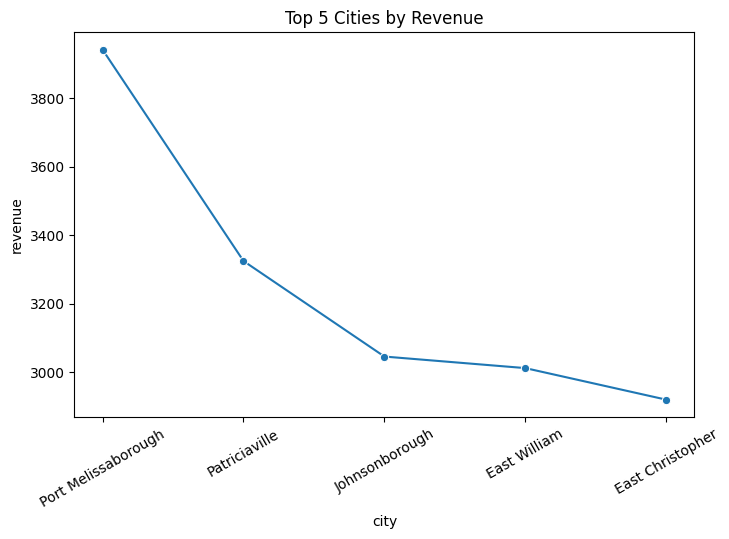

In [10]:
# 8. Top 5 Cities by Revenue
top_cities = df.groupBy("city") \
    .agg(_sum("order_value").alias("revenue")) \
    .orderBy(col("revenue").desc()) \
    .limit(5)

pdf8 = top_cities.toPandas()
plt.figure(figsize=(8,5))
sns.lineplot(x="city", y="revenue", data=pdf8, marker="o")
plt.title("Top 5 Cities by Revenue")
plt.xticks(rotation=30)
plt.show()

Conclusion

The dataset reveals a healthy, growing e-commerce environment with strong demand from mid-aged customers and metros, while younger customers and smaller towns provide future growth potential.

Strengths:

    Electronics drives consistent high revenue.
    
    Customer satisfaction is strong (4–5 star reviews dominate).
    
    Payment diversity ensures inclusivity.

Challenges:

    High cart abandonment and COD reliance in smaller towns.
    
    Seasonal revenue fluctuations, requiring stock planning.
    
    Negative reviews linked to logistics.

Recommendations:

    Focus on mid-age customer retention with loyalty rewards.
    
    Upsell & bundle low-margin items (Books/Fashion) with electronics.
    
    Introduce mid-week flash sales to balance demand.
    
    Promote digital payments with cashback in Tier-2/3 cities.
    
    Improve logistics to reduce delivery-related complaints.